In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pickle

In [2]:
# target = "target_close"
target = "close_percent_change_1"

In [3]:
# Load model
# model = pickle.load(open("../model/xgboost_model.pkl", "rb"))


model = xgb.XGBRegressor()
model.load_model("../model/xgboost_model.json")

In [4]:
# print features name
print(len(model.get_booster().feature_names))
model.get_booster().get_score()

492


{'open': 898.0,
 'high': 586.0,
 'low': 259.0,
 'close': 214.0,
 'adj close': 152.0,
 'volume': 553.0,
 'volitility_open_7': 411.0,
 'volitility_pct_change_7_open': 559.0,
 'high_low_7': 304.0,
 'high_close_7': 484.0,
 'low_close_7': 423.0,
 'true_range_7': 225.0,
 'average_true_range_7': 160.0,
 'open_rolling_mean_7': 41.0,
 'open_rolling_exp_mean_7': 30.0,
 'rsi_7': 529.0,
 'short_ema_12': 198.0,
 'long_ema_26': 150.0,
 'macd_12_26': 315.0,
 'signal_9': 310.0,
 'macd_hist_12_26_9': 386.0,
 'stochastic_oscillator_7': 448.0,
 'williams_r_7': 255.0,
 'on_balance_volume_1': 158.0,
 'volume_weighted_average_price_7': 14.0,
 'open_rolling_std_7': 120.0,
 'open_bollinger_upper_7': 12.0,
 'open_bollinger_lower_7': 15.0,
 'open_fib_0.236': 8.0,
 'open_fib_0.382': 4.0,
 'open_fib_0.618': 8.0,
 'open_fib_1.0': 9.0,
 'volitility_open_14': 167.0,
 'volitility_pct_change_14_open': 271.0,
 'high_low_14': 99.0,
 'high_close_14': 160.0,
 'low_close_14': 174.0,
 'true_range_14': 70.0,
 'average_true_r

In [5]:
# load predictions
df = pd.read_parquet("../data/predicted.parquet")

In [6]:
def normalize_column(data: pd.DataFrame, column: str | list) -> pd.DataFrame:
    if isinstance(column, str):
        data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min())
    elif isinstance(column, list):
        for col in column:
            data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())
    return data

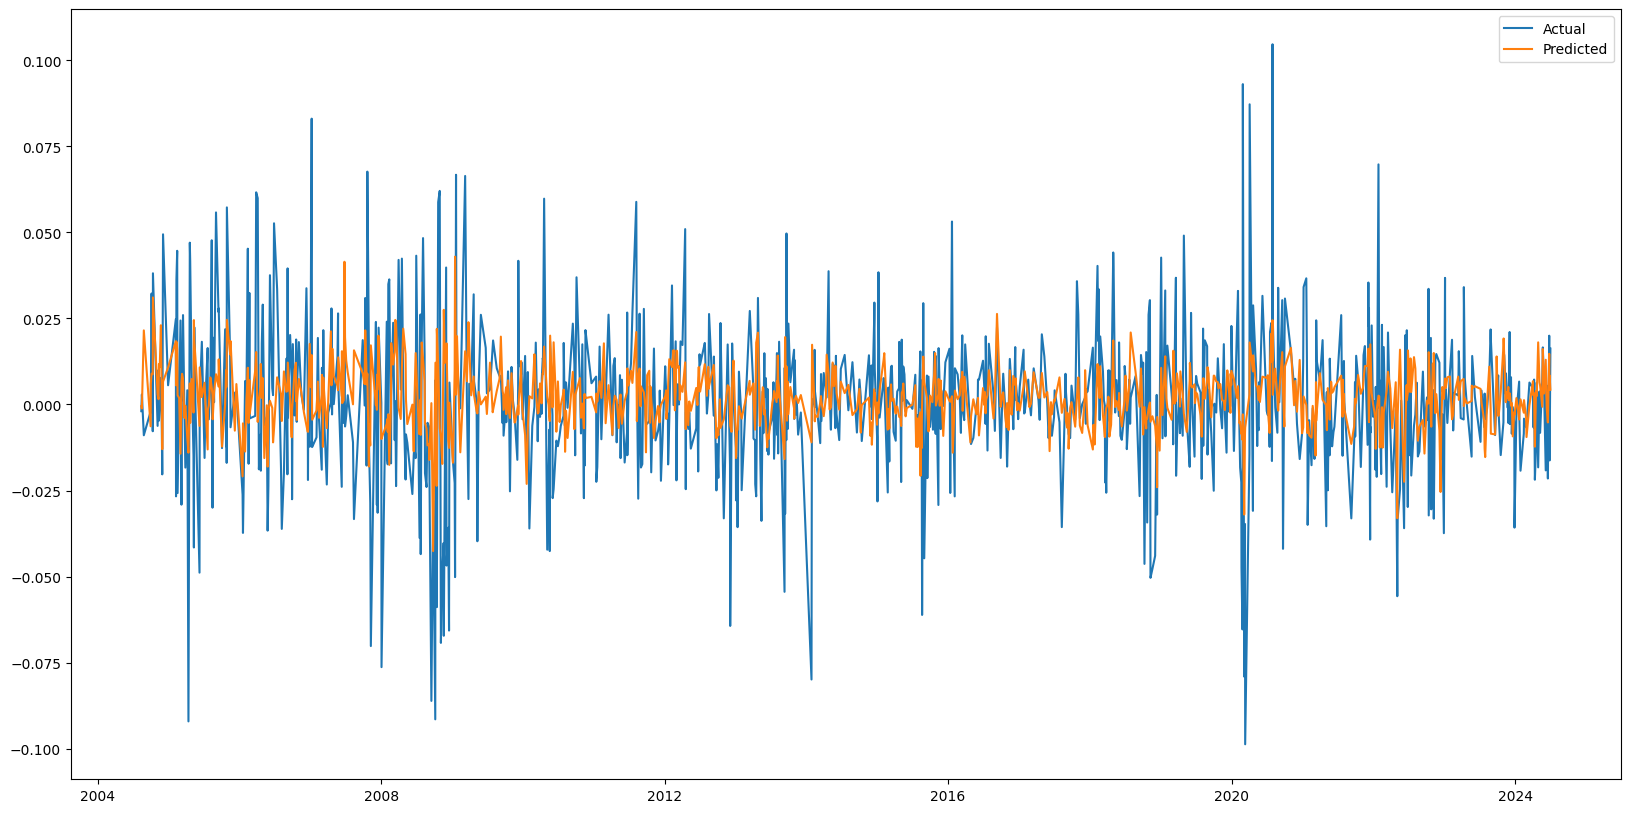

In [7]:
# Plot the predicted vs actual values
plt.figure(figsize=(20, 10))
plt.plot(df[target], label="Actual")
plt.plot(df["predicted"], label="Predicted")
plt.legend()
plt.show()

<Axes: xlabel='date', ylabel='value'>

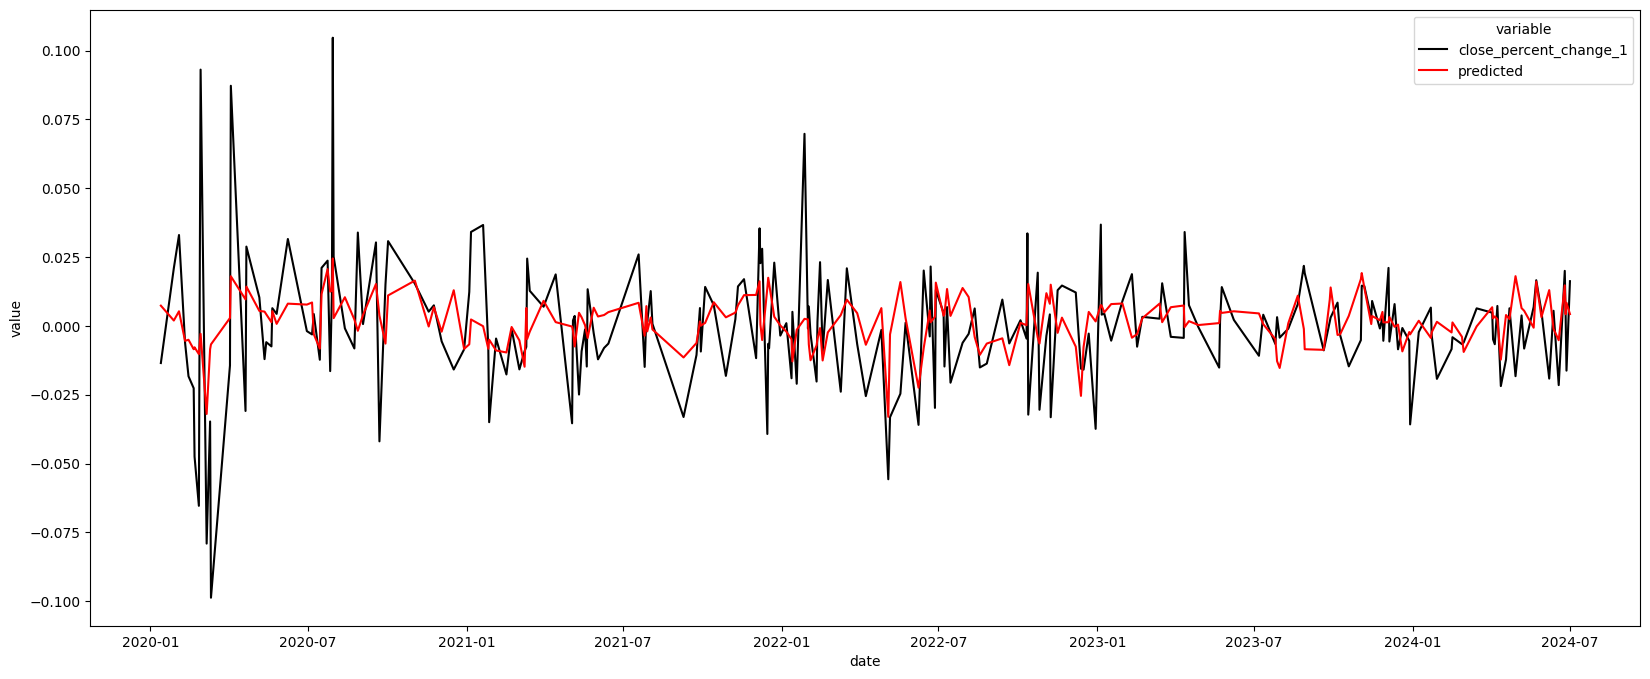

In [8]:
fig, ax = plt.subplots(figsize=(20, 8))
# Only 2008 - 2012 indexs 
df_date = df.loc["2020":"2024"]

sns.lineplot(
    df_date.reset_index().melt(id_vars=["date"], value_vars=[target, "predicted"]),
    y="value",
    x="date",
    hue="variable",
    linewidth=1.5,
    palette=['black', 'red'],
    ax=ax,
)

In [9]:
df_importance = pd.DataFrame()

importance_types = ["weight", "gain", "cover", "total_gain", "total_cover"]
for importance_type in importance_types:
    importance = model.get_booster().get_score(importance_type=importance_type)

    df_i = pd.DataFrame(importance.items(), columns=["feature", importance_type])

    if df_importance.empty:
        df_importance = df_i
    else:
        df_importance = pd.merge(df_importance, df_i, on="feature", how="outer")
df_importance


,feature,weight,gain,cover,total_gain,total_cover
0,adj close,152.0,0.000093,10.651316,0.014157,1619.0
1,average_true_range_14,72.0,0.000462,266.305542,0.033283,19174.0
2,average_true_range_30,77.0,0.000405,264.584412,0.031182,20373.0
3,average_true_range_7,160.0,0.000144,134.293747,0.023108,21487.0
4,close,214.0,0.000138,9.911215,0.029547,2121.0
...,...,...,...,...,...,...
458,week_of_year,173.0,0.000403,309.150299,0.069728,53483.0
459,williams_r_14,232.0,0.000722,338.314667,0.167489,78489.0
460,williams_r_30,160.0,0.000654,294.081238,0.104580,47053.0
461,williams_r_7,255.0,0.000368,373.396088,0.093892,95216.0


In [10]:
df_importance = normalize_column(df_importance, ["weight", "gain", "cover", "total_gain", "total_cover"])
df_importance_melted = df_importance.sort_values(by="weight", ascending=True).melt(id_vars=["feature"], value_vars=importance_types)
df_importance_melted

,feature,variable,value
0,close_fib_0.236,weight,0.000000
1,high_lag_52,weight,0.000000
2,high_lag_37,weight,0.000000
3,high_lag_36,weight,0.000000
4,high_lag_11,weight,0.000000
...,...,...,...
2310,rsi_7,total_cover,0.330646
2311,volume,total_cover,0.119442
2312,volitility_pct_change_7_open,total_cover,0.156928
2313,high,total_cover,0.006805


<Axes: xlabel='value', ylabel='feature'>

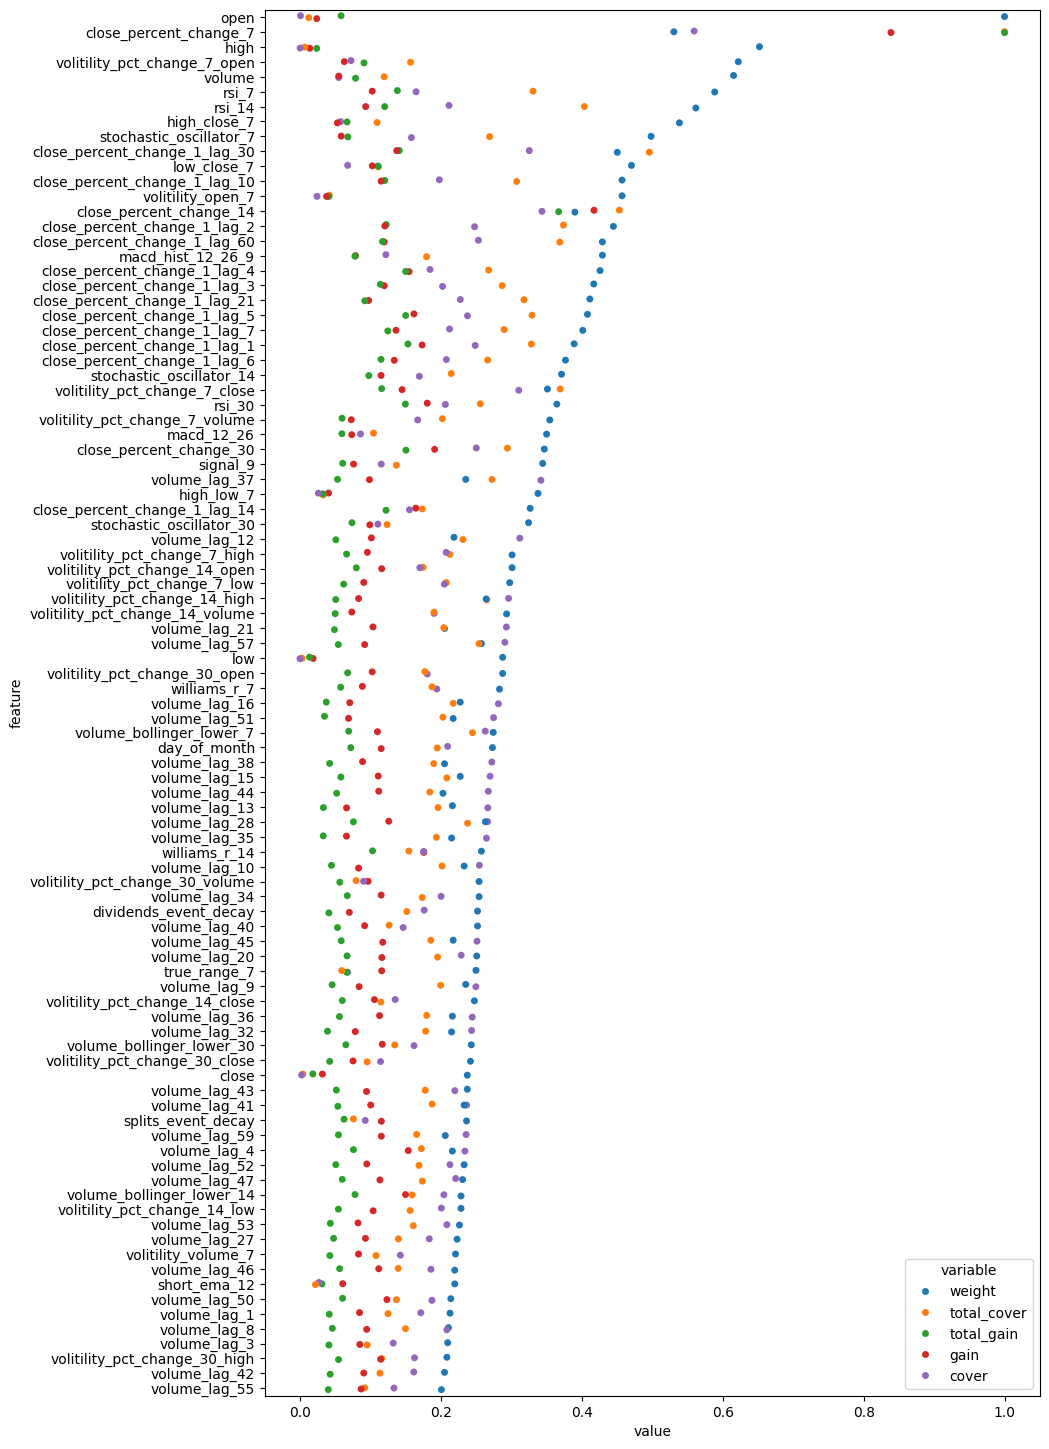

In [44]:
fig, ax = plt.subplots(figsize=(10, 18))
sns.stripplot(
    df_importance[df_importance["weight"] >= 0.2]
    .melt(id_vars=["feature"], value_vars=importance_types).sort_values(by="value", ascending=False),
    y="feature",
    x="value",
    hue="variable",
    ax=ax,
    jitter=True,
    legend="auto",
)

<Axes: xlabel='value', ylabel='feature'>

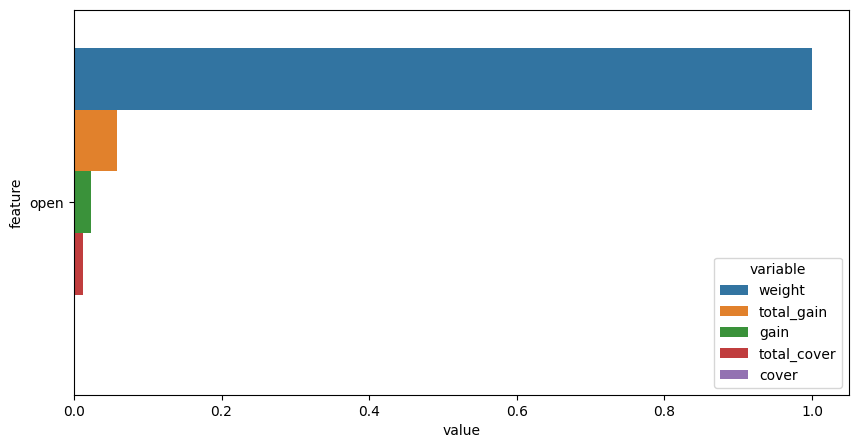

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(
    df_importance[df_importance["feature"] == "open"]
    .melt(id_vars=["feature"], value_vars=importance_types).sort_values(by="value", ascending=False),
    y="feature",
    x="value",
    hue="variable",
    ax=ax,
)

<Axes: xlabel='value', ylabel='feature'>

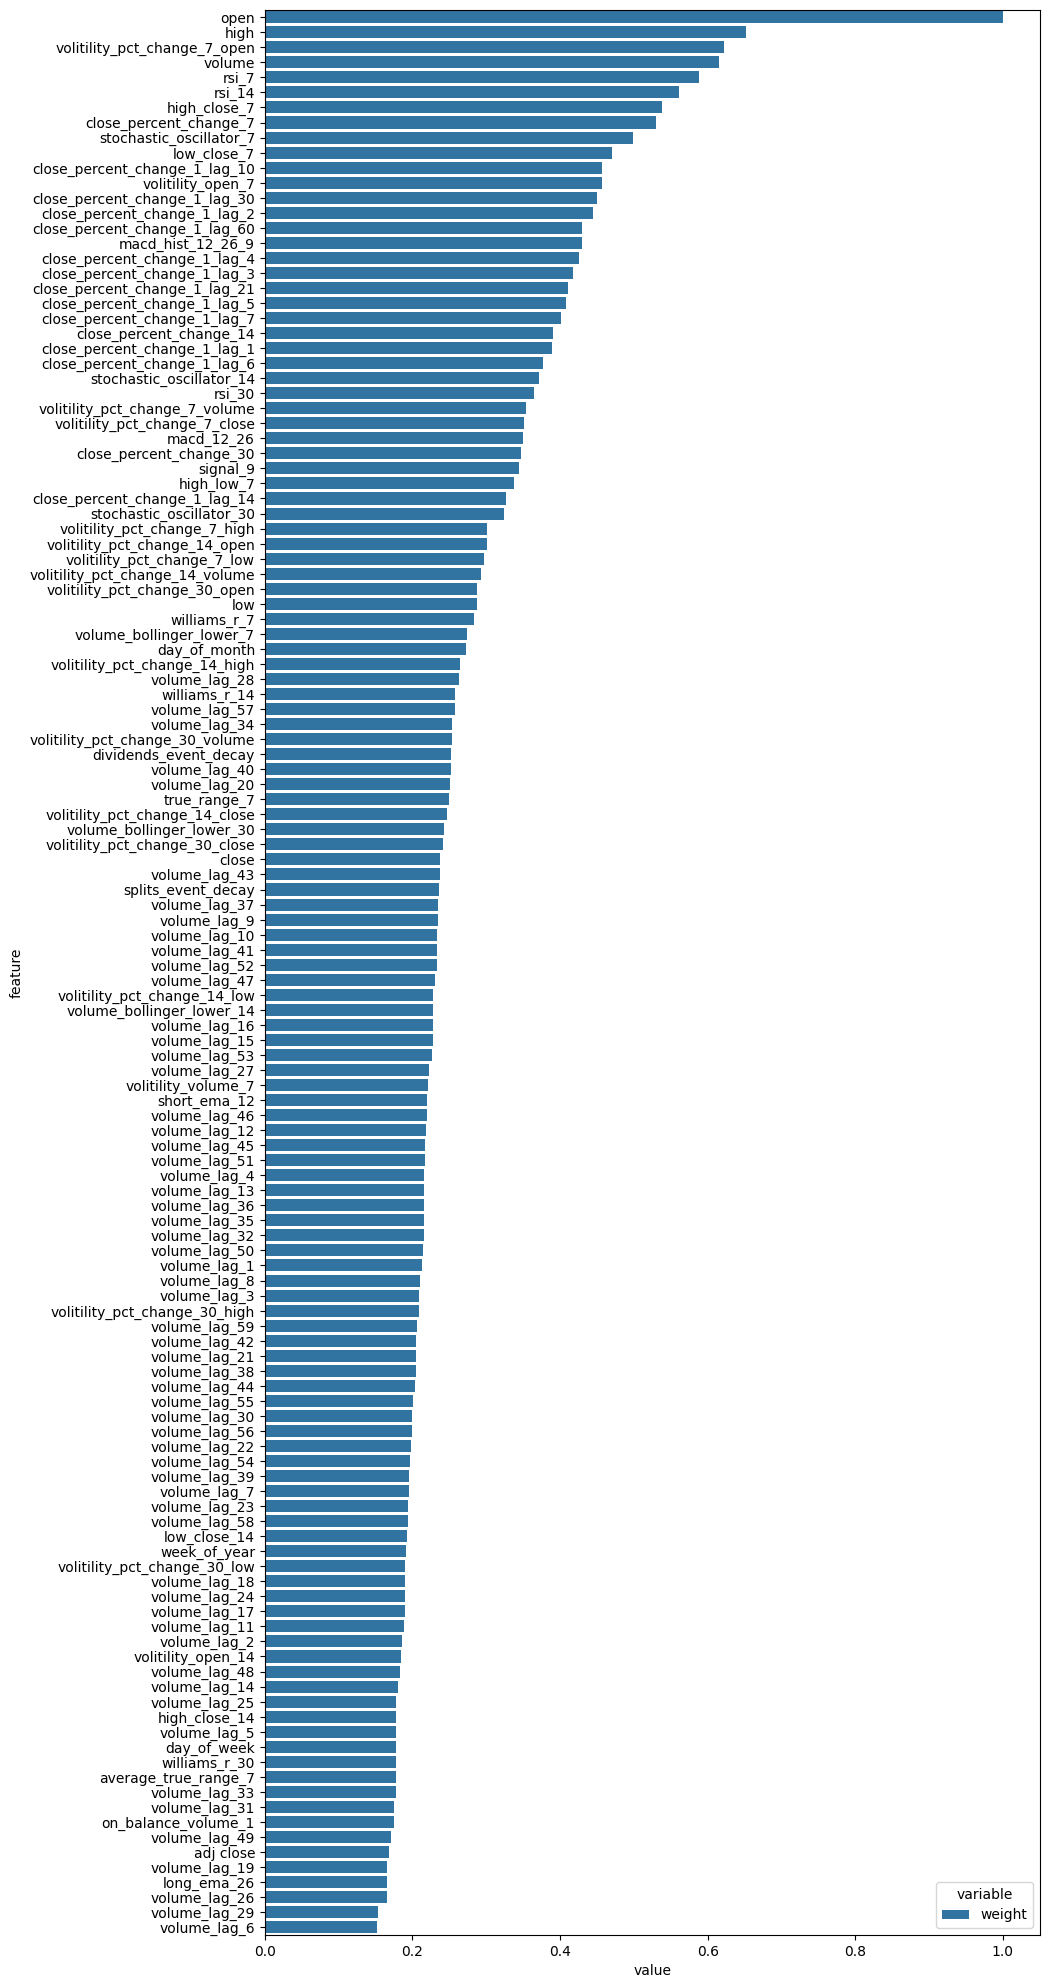

In [28]:
fig, ax = plt.subplots(figsize=(10, 25))
sns.barplot(
    df_importance[df_importance["weight"] >= 0.15][["feature", "weight"]]
    .melt(id_vars=["feature"], value_vars=["weight"]).sort_values(by="value", ascending=False),
    y="feature",
    x="value",
    hue="variable",
    ax=ax,
)

<Axes: xlabel='value', ylabel='feature'>

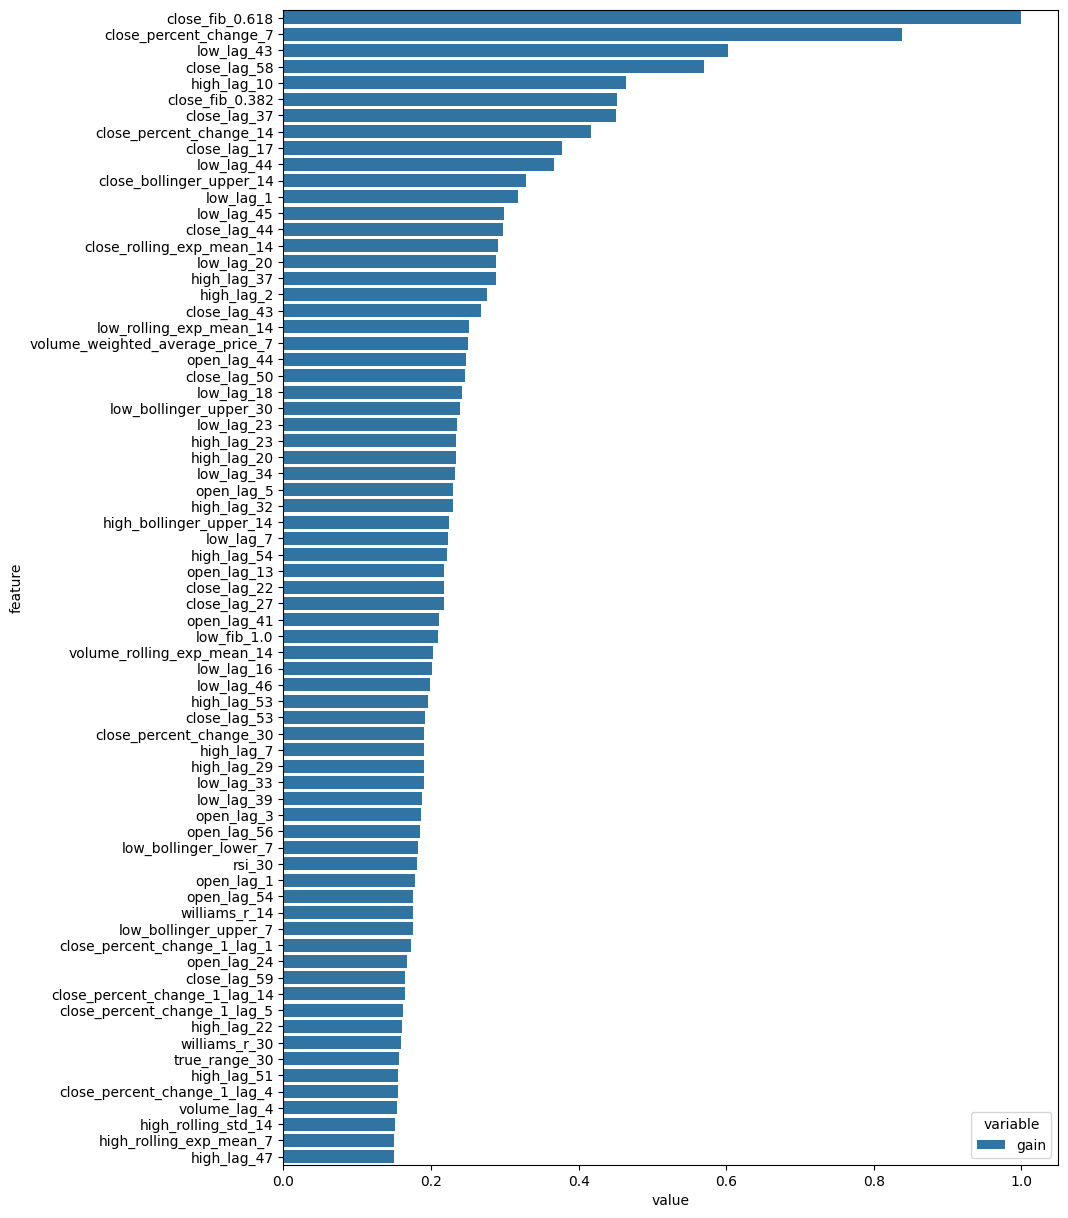

In [26]:
fig, ax = plt.subplots(figsize=(10, 15))
sns.barplot(
    df_importance[df_importance["gain"] >= 0.15][["feature", "gain"]]
    .melt(id_vars=["feature"], value_vars=["gain"]).sort_values(by="value", ascending=False),
    y="feature",
    x="value",
    hue="variable",
    ax=ax,
)

<Axes: xlabel='value', ylabel='feature'>

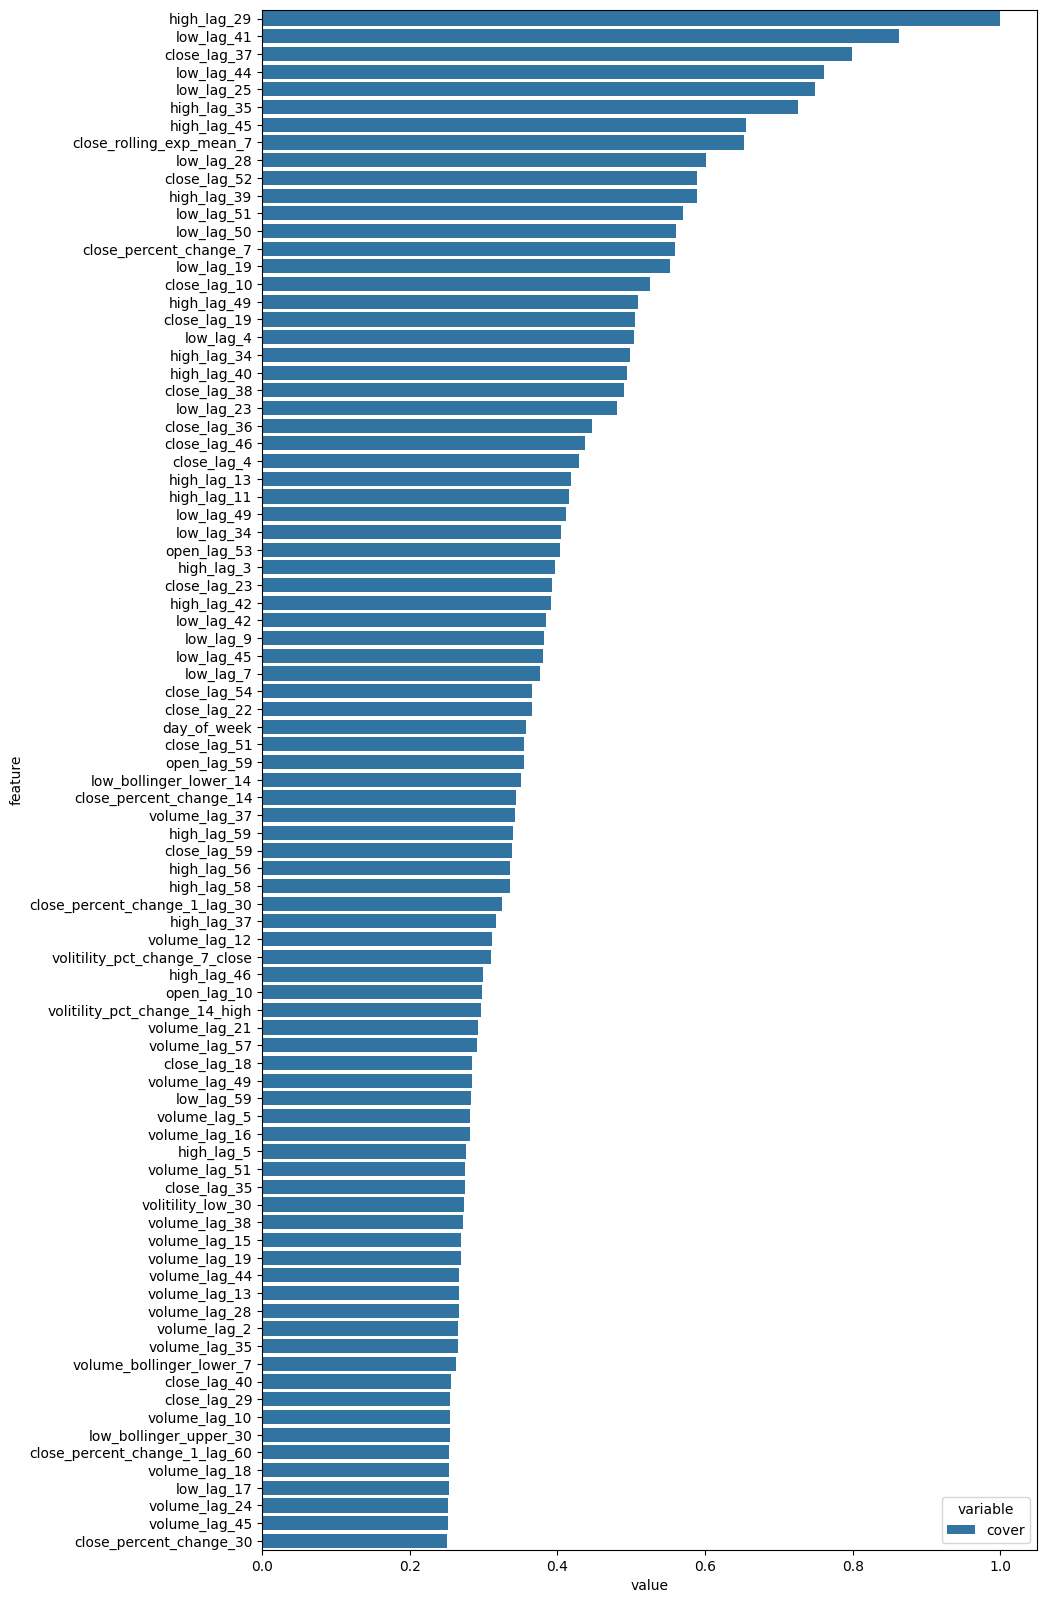

In [47]:
fig, ax = plt.subplots(figsize=(10, 20))
sns.barplot(
    df_importance[df_importance["cover"] >= 0.25][["feature", "cover"]]
    .melt(id_vars=["feature"], value_vars=["cover"]).sort_values(by="value", ascending=False),
    y="feature",
    x="value",
    hue="variable",
    ax=ax,
)